In [1]:
#Improt all required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from skimage.transform import rescale
import skimage.color as color
import cv2
from PIL import Image
from skimage.external import tifffile
from skimage.transform import resize
import tensorflow as tf
import keras
from keras import backend
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D,GlobalAveragePooling2D,Input,InputLayer
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model, load_model
from keras.optimizers import SGD, Adam
from keras.applications import ResNet50, VGG16, MobileNet, Xception, DenseNet121
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.backend import clear_session

## Image Augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import argparse
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import cv2
import os
from os import listdir
from tqdm import tqdm
import time
import csv
import pickle

from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

Using TensorFlow backend.


In [7]:
INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 256
DROPOUT_RATE = 0.5
EPOCHS = 25
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
NFOLDS = 2 # No of folds for cross validation
WORKERS = 4 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

TRAIN_PATH = 'train-jpg'
TEST_PATH = 'test-jpg'

TRAIN_CSV_PATH = 'train_v2.csv'
TEST_CSV_PATH = 'sample_submission_v2.csv'

In [8]:
# Construct dataframes holding training and test data information
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str) + '.jpg'
df_test['image_name'] = df_test['image_name'].astype(str) + '.jpg'

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

print(df_train.head())
print()
print(df_test.head())

    image_name                                       tags
0  train_0.jpg                               haze primary
1  train_1.jpg            agriculture clear primary water
2  train_2.jpg                              clear primary
3  train_3.jpg                              clear primary
4  train_4.jpg  agriculture clear habitation primary road

   image_name                                        tags
0  test_0.jpg  [primary, clear, agriculture, road, water]
1  test_1.jpg  [primary, clear, agriculture, road, water]
2  test_2.jpg  [primary, clear, agriculture, road, water]
3  test_3.jpg  [primary, clear, agriculture, road, water]
4  test_4.jpg  [primary, clear, agriculture, road, water]


In [14]:
df_test.head()

,image_name,tags
0,test_0.jpg,"[primary, clear, agriculture, road, water]"
1,test_1.jpg,"[primary, clear, agriculture, road, water]"
2,test_2.jpg,"[primary, clear, agriculture, road, water]"
3,test_3.jpg,"[primary, clear, agriculture, road, water]"
4,test_4.jpg,"[primary, clear, agriculture, road, water]"


In [15]:
df_test.shape

(61191, 2)

In [16]:
# These files are numpy Arrays with shape Nx1
X_train_files = np.array(df_train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))
y_train = np.array(df_train['tags'].tolist())

In [18]:
# There are 17 Labels and each image is tagged with multiple labels
# Lets print out the unique label list

labels = []

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
        
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


conventional_mine is tagged least no of times: 99
primary is tagged max no of times: 37512


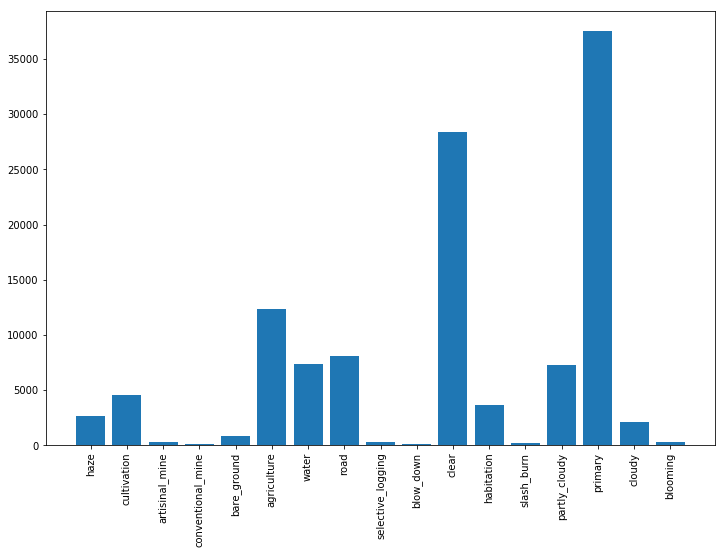

In [19]:
#Distribution of the labels :

plt.figure(figsize=(12, 8))

labels_count = {}

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
min_label = min(labels_count, key=labels_count.get)
max_label = max(labels_count, key=labels_count.get)

print(min_label+" is tagged least no of times: "+str(labels_count[min_label]))
print(max_label+" is tagged max no of times: "+str(labels_count[max_label]))
            
plt.bar(range(len(labels_count)), list(labels_count.values()), align='center')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation=90)

plt.show()

In [10]:
# Define model here:

def create_model():
    base_model_res = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))

    for layer in base_model_res.layers:
        layer.trainable = True


    model = Sequential([
        base_model_res,
        Flatten(), 
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(17, activation='sigmoid')
    ])
    
    return model

model = create_model()
model.summary()

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 17)                2193      
Total params: 27,784,337
Trainable params: 27,731,217
Non-trainable params: 53,120
_________________________________________________________________


In [20]:
#Define evaluation metric - f2 score :
def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

In [13]:
#Run the model  with k-fold cross validation:

num_fold = 0
EPOCHS = 23

y_test = []

folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=1).split(X_train_files, y_train)

for train_index, val_index in folds:
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])
    
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=TEST_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        shuffle=False,
    )

    model_path_of_fold = os.path.join('', 'weights_of_fold_' + str(num_fold) + '.h5')
    
    model = create_model()
    
    adam = Adam(learning_rate=LR)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f2_score])
    
    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='val_f2_score', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]
    
    model.fit_generator(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

    model.load_weights(model_path_of_fold)

    p_test = model.predict_generator(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)
    y_test.append(p_test)
    
    num_fold+=1

Found 20239 validated image filenames belonging to 17 classes.
Found 20240 validated image filenames belonging to 17 classes.
Found 61191 validated image filenames belonging to 17 classes.
Epoch 1/23
80/80 [==============================] - 289s 4s/step - loss: 0.3173 - f2_score: 0.6731 - val_loss: 0.3076 - val_f2_score: 0.6647
Epoch 2/23
80/80 [==============================] - 94s 1s/step - loss: 0.2434 - f2_score: 0.7095 - val_loss: 0.2766 - val_f2_score: 0.6524
Epoch 3/23
80/80 [==============================] - 94s 1s/step - loss: 0.2302 - f2_score: 0.7196 - val_loss: 0.2695 - val_f2_score: 0.6597
Epoch 4/23
80/80 [==============================] - 94s 1s/step - loss: 0.2214 - f2_score: 0.7294 - val_loss: 0.3024 - val_f2_score: 0.6710
Epoch 5/23
80/80 [==============================] - 94s 1s/step - loss: 0.2110 - f2_score: 0.7400 - val_loss: 0.3055 - val_f2_score: 0.7008
Epoch 6/23
80/80 [==============================] - 94s 1s/step - loss: 0.2086 - f2_score: 0.7399 - val_loss: 

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/23
80/80 [==============================] - 121s 2s/step - loss: 0.3008 - f2_score: 0.6646 - val_loss: 0.3022 - val_f2_score: 0.6513
Epoch 2/23
80/80 [==============================] - 89s 1s/step - loss: 0.2436 - f2_score: 0.6985 - val_loss: 0.2190 - val_f2_score: 0.6446
Epoch 3/23
80/80 [==============================] - 89s 1s/step - loss: 0.2311 - f2_score: 0.7128 - val_loss: 0.4020 - val_f2_score: 0.6492
Epoch 4/23
80/80 [==============================] - 89s 1s/step - loss: 0.2213 - f2_score: 0.7215 - val_loss: 0.2819 - val_f2_score: 0.6811
Epoch 5/23
80/80 [==============================] - 89s 1s/step - loss: 0.2132 - f2_score: 0.7289 - val_loss: 0.2645 - val_f2_score: 0.6926
Epoch 6/23
80/80 [==============================] - 89s 1s/step - loss: 0.2086 - f2_score: 0.7362 - val_loss: 0.2326 - val_f2_score: 0.7250
Epoch 7/23
80/80 [==============================] - 89s 1s/step - loss: 0.2040 - f2_score: 0.7455 - val_loss: 0.2143 - val_f2_score: 0.7327
Epoch 8/23
80/80 [=

In [14]:
# Average the k results obtained from k-fold cross validation

result = np.array(y_test[0])
for i in range(1, NFOLDS):
    result += np.array(y_test[i])
result /= NFOLDS
result = pd.DataFrame(result, columns = labels)
result.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.032107,0.000302,0.001195,0.006295,0.000577,0.982127,0.000671,0.000073,0.016109,0.002062,0.003604,0.005781,0.999703,0.008671,0.001877,0.000407,0.022269
1,0.127948,0.002845,0.005366,0.022346,0.011661,0.977883,0.001765,0.000761,0.131698,0.021598,0.006002,0.012979,0.996191,0.076828,0.018468,0.004678,0.177758
2,0.122356,0.001327,0.003603,0.002276,0.001111,0.018424,0.039560,0.002527,0.055393,0.027997,0.002136,0.919085,0.968436,0.065403,0.003074,0.002304,0.193352
3,0.114908,0.001722,0.003993,0.033316,0.005304,0.964625,0.001245,0.000484,0.082456,0.011354,0.005864,0.021828,0.998643,0.052305,0.013874,0.001963,0.076966
4,0.087644,0.002781,0.003216,0.002646,0.003299,0.013413,0.403208,0.000956,0.040767,0.021974,0.010143,0.581076,0.597054,0.069828,0.002514,0.004442,0.157097


In [15]:
#Pickling the result df

import pickle
pickle1_out = open('result_res_23ep_2cv.pickle', 'wb')
pickle.dump(result, pickle1_out, protocol=4)
pickle1_out.close()

In [16]:
result.to_csv('res_res_25ep_2cv.csv')

In [44]:
df_test.head()

,image_name,tags
0,test_0.jpg,"[primary, clear, agriculture, road, water]"
1,test_1.jpg,"[primary, clear, agriculture, road, water]"
2,test_2.jpg,"[primary, clear, agriculture, road, water]"
3,test_3.jpg,"[primary, clear, agriculture, road, water]"
4,test_4.jpg,"[primary, clear, agriculture, road, water]"


In [17]:
preds = []
for i in range(result.shape[0]):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
    
df_test['tags'] = preds
df_test['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
df_test.to_csv('submit_res_23ep_2cv.csv', index=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
df_test

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear primary
4,test_4,cloudy partly_cloudy primary
...,...,...
61186,file_9995,cloudy primary water
61187,file_9996,agriculture clear primary road water
61188,file_9997,clear primary
61189,file_9998,cloudy haze primary water


#### Kaggle Score : 0.80544 ( 5 epochs , lr= 0.001, CV= 3 fold)

Kaggle Score 0.86205:  ( 23 epochs , lr= 0.0001, CV= 2 fold)

In [4]:
# def create_model():
#     base_model_res = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))

#     for layer in base_model_res.layers:
#         layer.trainable = True


#     model = Sequential([
#         base_model_res,
#         Flatten(), 
#         Dense(128, activation='relu'),
#         Dropout(0.2),
#         Dense(17, activation='sigmoid')
#     ])
    
#     return model

# model = create_model()
# model.summary()

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 17)                2193      
Total params: 27,784,337
Trainable params: 27,731,217
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# Re-creating training dataset to get precision and recall report

train_df = pd.DataFrame(list(zip(X_train_files, y_train)), columns = ['image_name', 'tags'])
train_df['tags_list'] = train_df['tags'].apply(lambda x: x.split(' '))
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags_list',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )

In [68]:
train_df.shape

(40479, 3)

In [ ]:
## Rebuild the model to predict for train data

model.load_weights('weights_of_fold_1.h5')

In [105]:
p_test = model.predict_generator(train_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

In [106]:
len(p_test)

40479

In [107]:
result_train = pd.DataFrame(p_test, columns = labels)

In [108]:
result_train[:5]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.959481,0.000644,0.015785,0.002385,0.000091,0.932202,0.003347,0.001451,0.124523,0.333116,0.004229,0.086624,0.969783,0.748962,0.002271,0.000802,0.079988
1,0.764134,0.003376,0.038155,0.008678,0.002596,0.974283,0.004694,0.003155,0.353917,0.154455,0.004690,0.015895,0.994118,0.274701,0.020306,0.034309,0.242263
2,0.007013,0.000014,0.000416,0.001181,0.000085,0.996256,0.000194,0.000094,0.004819,0.001239,0.000145,0.001835,0.999637,0.004200,0.000607,0.000061,0.019440
3,0.838967,0.000448,0.191910,0.004169,0.000362,0.930683,0.007988,0.003201,0.048235,0.065078,0.003279,0.042653,0.747220,0.480374,0.014688,0.001535,0.108453
4,0.027289,0.000184,0.000089,0.000765,0.000281,0.026405,0.000679,0.001354,0.017308,0.002281,0.000606,0.974311,0.998199,0.016288,0.000156,0.000223,0.028926


In [109]:
len(result_train)

40479

In [110]:
preds = []
THRES=0.2
for i in range(result_train.shape[0]):
    a = result_train.ix[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
df_train['tags_list_pred'] = preds
df_train['image_name'] = df_train['image_name'].astype(str).str.slice(stop=-4)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [112]:
df_train['tags_list_pred1'] = df_train['tags_list_pred'].apply(lambda x: x.split(' '))
df_train['tags1'] = df_train['tags'].apply(lambda x: x.split(' '))

In [114]:
df_train_actual = df_train[['image_name','tags1']]

In [115]:
df_train_actual

,image_name,tags1
0,tra,"[haze, primary]"
1,tra,"[agriculture, clear, primary, water]"
2,tra,"[clear, primary]"
3,tra,"[clear, primary]"
4,tra,"[agriculture, clear, habitation, primary, road]"
...,...,...
40474,train_4,"[clear, primary]"
40475,train_4,[cloudy]
40476,train_4,"[agriculture, clear, primary]"
40477,train_4,"[agriculture, clear, primary, road]"


In [116]:
#One hot encoding for actual and predicted labels 

from sklearn.preprocessing import MultiLabelBinarizer
resnet = MultiLabelBinarizer()

res = pd.DataFrame(resnet.fit_transform(df_train_actual['tags1']),
                   columns=resnet.classes_,
                   index=df_train_actual.index)

res

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40474,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
40475,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
40476,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
40477,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0


In [117]:
# create a data frame for above matrix
df_train_pred = df_train[['image_name','tags_list_pred1']]
res_pred = pd.DataFrame(resnet.fit_transform(df_train_pred['tags_list_pred1']),
                   columns=resnet.classes_,
                   index=df_train_pred.index)

res_pred

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0
1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40474,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
40475,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
40476,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
40477,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [118]:
#Get the recall and precision report using sklearn

from sklearn.metrics import classification_report
import numpy as np
print(classification_report(res, res_pred, target_names=labels))

                   precision    recall  f1-score   support

      agriculture       0.30      0.42      0.35     12315
   artisinal_mine       0.01      0.02      0.01       339
      bare_ground       0.02      0.01      0.01       862
         blooming       0.02      0.02      0.02       332
        blow_down       0.00      0.00      0.00        98
            clear       0.70      0.79      0.74     28431
           cloudy       0.05      0.07      0.06      2089
conventional_mine       0.00      0.01      0.00       100
      cultivation       0.11      0.23      0.15      4477
       habitation       0.09      0.12      0.10      3660
             haze       0.07      0.09      0.08      2697
    partly_cloudy       0.18      0.22      0.20      7261
          primary       0.93      0.98      0.95     37513
             road       0.19      0.29      0.23      8071
selective_logging       0.01      0.01      0.01       340
       slash_burn       0.01      0.01      0.01       